# MNIST Semi-Supervised Graph Convolutional Network

In [20]:
#NOTE: This code implements libraries and some examples from Spektral https://spektral.graphneural.network/ a Python library for graph deep learning, based on the Keras API and TensorFlow 2.


In [2]:
#setup

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from spektral.datasets import mnist
from spektral.layers import GraphConv
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
import numpy as np
from scipy import sparse as sp




In [3]:
#function to split data

def splitData(xTrain, yTrain, labeledSize, selectionType):
    idx = np.array([])
    if (selectionType == "Group" and labeledSize != 50000):
        size = int(labeledSize/10)
        idx = np.append(idx, np.random.choice(np.where(yTrain == 0)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 1)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 2)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 3)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 4)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 5)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 6)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 7)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 8)[0], 
                                              size, replace = False))
        idx = np.append(idx, np.random.choice(np.where(yTrain == 9)[0], 
                                              size, replace = False))
    elif(selectionType == "Random"):
        idx = np.random.choice(yTrain.shape[0], labeledSize, replace = False)
    else:
        idx = np.append(idx,range(0,labeledSize))
        
    idx = idx.astype(int)
    return idx

In [4]:
#create custom loss function for semi-supervised learning

from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy

def masked_categorical_crossentropy(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = K.all(K.equal(y_true, np.ones(10)), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())

    # multiply categorical_crossentropy with the mask
    loss = K.categorical_crossentropy(y_true, y_pred) * mask
    
    # take average w.r.t. the number of unmasked entries
    #return loss
    return K.sum(loss)

In [5]:
#transform output data to one hot encoding

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


In [6]:
def load_data(k_nn):
    # Load data
    X_train, y_train, X_val, y_val, X_test, y_test, adj = mnist.load_data(k=k_nn)
    X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
    N = X_train.shape[-2]      # Number of nodes in the graphs
    F = X_train.shape[-1]      # Node features dimensionality
    fltr = transform_matrix(adj)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, fltr, N, F


In [7]:
#apply matrix normalization
def transform_matrix(adj):
    
    #Transform Adjecency Matrix
    fltr = adj.copy()
    #create diagonal matrix with shape of A
    I = sp.eye(adj.shape[-1], dtype=adj.dtype)
    A_tilde = adj + I
    #normalize adjecency matrix
    #degree matrix of A raised to the -0.5
    degrees = np.power(np.array(A_tilde.sum(1)), -0.5).flatten()
    degrees[np.isinf(degrees)] = 0.
    normalized_D = sp.diags(degrees)
    #D^{0.5}*A_tilde*D^{0.5}
    fltr = normalized_D.dot(A_tilde).dot(normalized_D)
    fltr.sort_indices()
    return fltr

In [8]:
#Define parameters

# Regularization rate for l2
l2_reg = 5e-4
#Learning rate
learning_rate = 1e-3
#batch size
batch_size = 32       
#training epochs
epochs = 5
#patience
es_patience = 10
#random distribution type
selectionType = "Group"
#final class dimension
n_out = 10
#hidden_layers
hidden_units = 32



# Run Model

In [9]:
#run model for each label size 
k_nn_values = [4,8,24]
labelSize = [100, 500, 1000, 2000, 5000, 10000, 25000,50000]
loss_list = []
accuracy_list = []
for k_nn in k_nn_values:
    print("Adj Matrix with KNN K=",k_nn)
    for labeledSize in labelSize:
        
        #load data with knn parameters
        X_train, y_train, X_val, y_val, X_test, y_test, fltr, N, F = load_data(k_nn)
        #Model architecture
        X_in = Input(shape=(N, F))
        A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))
        #1st GCN Layer using fixed Adjecency matrix A
        graph_conv = GraphConv(hidden_units,
                               activation='relu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)([X_in, A_in])
        #2nd GCN Layer using fixed Adjecency matrix A
        graph_conv = GraphConv(hidden_units,
                               activation='relu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)([graph_conv, A_in])
        flatten = Flatten()(graph_conv)
        fc = Dense(512, activation='relu')(flatten)
        #softmax output
        output = Dense(n_out, activation='softmax')(fc)


        #Build model
        model = Model(inputs=[X_in, A_in], outputs=output)
        optimizer = Adam(lr=learning_rate)
        model.compile(optimizer=optimizer,
                      loss=masked_categorical_crossentropy,
                      metrics=['accuracy'])
        #mask unlabeled data in y train
        print("labeled size:",labeledSize)
        labeledindex= splitData(X_train, y_train, labeledSize, selectionType)

        #one hote encoding
        y_val_oh = one_hot(y_val,10)
        y_train_oh = one_hot(y_train,10)
        y_test_oh = one_hot(y_test,10)

        #maske for semi-supervised
        y_train_copy = y_train_oh
        y_train_masked =  y_train_copy.copy()
        y_train_masked[[i for i in range(y_train_oh.shape[0]) if i not in labeledindex],] = np.ones(10)
        print("unlabeled:",sum(np.sum(y_train_masked,axis=1) == 10))

        # Train model
        validation_data = (X_val, y_val_oh)
        model.fit(X_train,
                  y_train_masked,
                  batch_size=batch_size,
                  validation_data=validation_data,
                  epochs=epochs,
                  callbacks=[
                      EarlyStopping(patience=es_patience, restore_best_weights=True)
                  ])

        # Evaluate model
        print('Evaluating model.')
        eval_results = model.evaluate(X_test,
                                      y_test_oh,
                                      batch_size=batch_size)
        print('Done.\n'
              'Test loss: {}\n'
              'Test acc: {}'.format(*eval_results))
        accuracy_list.append(eval_results[1])
        loss_list.append(eval_results[0])


Adj Matrix with KNN K= 4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
labeled size: 100
unlabeled: 49900
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 151s 3ms/sample - loss: 0.1506 - accuracy: 0.1027 - val_loss: 55.9689 - val_accuracy: 0.3846
Epoch 2/5
50000/50000 [==============================] - 162s 3ms/sample - loss: 0.0796 - accuracy: 0.1147 - val_loss: 34.4491 - val_accuracy: 0.6734
Epoch 3/5
50000/50000 [==============================] - 153s 3ms/sample - loss: 0.0408 - accuracy: 0.1134 - val_loss: 27.6731 - val_accuracy: 0.7272
Epoch 4/5
50000/50000 [==============================] - 155s 3ms/sample - loss: 0.0324 - accuracy: 0.1210 - val_loss: 28.9068 - val_accuracy: 0.7247
Epoch 5/5
50000/50000 [==============================] - 164s 3ms/sample - loss: 0.0161 - accuracy: 0.1128 - val_loss: 40.7159 - val_accuracy: 0.7024
Evaluating model.
10000/10000 [============================

50000/50000 [==============================] - 155s 3ms/sample - loss: 1.6641 - accuracy: 0.9831 - val_loss: 2.5509 - val_accuracy: 0.9751
Evaluating model.
10000/10000 [==============================] - 4s 403us/sample - loss: 2.3328 - accuracy: 0.9790
Done.
Test loss: 2.332773121854663
Test acc: 0.9789999723434448
Adj Matrix with KNN K= 8
labeled size: 100
unlabeled: 49900
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 159s 3ms/sample - loss: 0.1561 - accuracy: 0.1884 - val_loss: 73.5433 - val_accuracy: 0.1068
Epoch 2/5
50000/50000 [==============================] - 158s 3ms/sample - loss: 0.1412 - accuracy: 0.0970 - val_loss: 42.9740 - val_accuracy: 0.5500
Epoch 3/5
50000/50000 [==============================] - 147s 3ms/sample - loss: 0.0706 - accuracy: 0.0772 - val_loss: 31.2479 - val_accuracy: 0.6939
Epoch 4/5
50000/50000 [==============================] - 149s 3ms/sample - loss: 0.0411 - accuracy: 0.0996 - val_loss: 34.

50000/50000 [==============================] - 156s 3ms/sample - loss: 1.7822 - accuracy: 0.9820 - val_loss: 3.7012 - val_accuracy: 0.9659
Evaluating model.
10000/10000 [==============================] - 4s 407us/sample - loss: 3.3175 - accuracy: 0.9677
Done.
Test loss: 3.3175221540510655
Test acc: 0.9677000045776367
Adj Matrix with KNN K= 24
labeled size: 100
unlabeled: 49900
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 159s 3ms/sample - loss: 0.1539 - accuracy: 0.2442 - val_loss: 58.7070 - val_accuracy: 0.4759
Epoch 2/5
50000/50000 [==============================] - 159s 3ms/sample - loss: 0.1013 - accuracy: 0.1137 - val_loss: 45.1325 - val_accuracy: 0.5290
Epoch 3/5
50000/50000 [==============================] - 168s 3ms/sample - loss: 0.0705 - accuracy: 0.0949 - val_loss: 34.8049 - val_accuracy: 0.6664
Epoch 4/5
50000/50000 [==============================] - 194s 4ms/sample - loss: 0.0396 - accuracy: 0.0935 - val_loss: 3

50000/50000 [==============================] - 152s 3ms/sample - loss: 2.9646 - accuracy: 0.9705 - val_loss: 3.5318 - val_accuracy: 0.9657
Evaluating model.
10000/10000 [==============================] - 5s 465us/sample - loss: 3.4472 - accuracy: 0.9657
Done.
Test loss: 3.4471995747685433
Test acc: 0.9656999707221985


In [10]:
accuracy_list

[0.7038,
 0.786,
 0.8726,
 0.909,
 0.9341,
 0.9622,
 0.9713,
 0.979,
 0.726,
 0.8545,
 0.9004,
 0.9156,
 0.9391,
 0.9491,
 0.964,
 0.9677,
 0.671,
 0.7618,
 0.8364,
 0.8772,
 0.9333,
 0.9441,
 0.9515,
 0.9657]

In [9]:
accuracy_list

[0.6918,
 0.7127,
 0.8243,
 0.9145,
 0.9407,
 0.946,
 0.9609,
 0.9702,
 0.6137,
 0.8607,
 0.859,
 0.9027,
 0.9438,
 0.9509,
 0.9605,
 0.9768,
 0.4432,
 0.7319,
 0.814,
 0.8548,
 0.929,
 0.9397,
 0.9512,
 0.9578]

In [17]:
loss_list

[39.130341612243654,
 30.500734205913545,
 16.812455882143976,
 11.016276840609311,
 7.560028124862909,
 4.651462504529953,
 3.159700453552604,
 2.332773121854663,
 33.15847632598877,
 18.21151882261038,
 11.923837749314307,
 11.474578426969051,
 6.5458336008667946,
 5.7352464566886425,
 3.670395508861542,
 3.3175221540510655,
 55.43049836730957,
 25.592925579833985,
 15.48977822341919,
 13.006189461517334,
 7.306705813395977,
 6.313263661122322,
 4.86595179951191,
 3.4471995747685433]

# Supervised Learning Version


In [22]:
#Define parameters
# Regularization rate for l2
l2_reg = 5e-4
#Learning rate
learning_rate = 1e-3
#batch size
batch_size = 32       
#training epochs
epochs = 5
#patience
es_patience = 10
#random distribution type
selectionType = "Group"
#final class dimension
n_out = 10
#hidden_units
hidden_units = 32
#load data with knn parameters
X_train, y_train, X_val, y_val, X_test, y_test, fltr, N, F = load_data(k_nn)


In [23]:
#run model for each label size 

labelSize = [100, 500, 1000, 2000, 5000, 10000, 25000, 50000]
loss_list_sup = []
accuracy_list_sup = []

for labeledSize in labelSize:
    
    #Model architecture
    X_in = Input(shape=(N, F))
    A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))
    #1st GCN Layer using fixed Adjecency matrix A
    graph_conv = GraphConv(hidden_units,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])
    #2nd GCN Layer using fixed Adjecency matrix A
    graph_conv = GraphConv(hidden_units,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([graph_conv, A_in])
    flatten = Flatten()(graph_conv)
    fc = Dense(512, activation='relu')(flatten)
    #softmax output
    output = Dense(n_out, activation='softmax')(fc)
    
    #Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=masked_categorical_crossentropy,
                  metrics=['accuracy'])

    #mask unlabeled data in y train
    print("labeled size:",labeledSize)
    labeledindex= splitData(X_train, y_train, labeledSize, selectionType)
    
    #one hote encoding
    y_val_oh = one_hot(y_val,10)
    y_train_oh = one_hot(y_train,10)
    y_test_oh = one_hot(y_test,10)
    
    #train only on labeled data
    y_train_copy = y_train_oh
    X_train_copy = X_train
    X_train_copy = X_train_copy[labeledindex]
    y_train_copy = y_train_copy[labeledindex]
    print("X train size:",X_train_copy.shape)
    
    
    # Train model
    validation_data = (X_val, y_val_oh)
    model.fit(X_train_copy,
              y_train_copy,
              batch_size=batch_size,
              validation_data=validation_data,
              epochs=epochs,
              callbacks=[
                  EarlyStopping(patience=es_patience, restore_best_weights=True)
              ])
    
    # Evaluate model
    print('Evaluating model.')
    eval_results = model.evaluate(X_test,
                                  y_test_oh,
                                  batch_size=batch_size)
    print('Done.\n'
          'Test loss: {}\n'
          'Test acc: {}'.format(*eval_results))
    accuracy_list_sup.append(eval_results[1])
    loss_list_sup.append(eval_results[0])
    
    


labeled size: 100
X train size: (100, 784, 1)
Train on 100 samples, validate on 10000 samples
Epoch 1/5
100/100 [==============================] - 5s 54ms/sample - loss: 71.8069 - accuracy: 0.1300 - val_loss: 64.8066 - val_accuracy: 0.3351
Epoch 2/5
100/100 [==============================] - 5s 53ms/sample - loss: 54.1307 - accuracy: 0.5100 - val_loss: 44.0209 - val_accuracy: 0.5377
Epoch 3/5
100/100 [==============================] - 5s 50ms/sample - loss: 33.3108 - accuracy: 0.6100 - val_loss: 32.8507 - val_accuracy: 0.6737
Epoch 4/5
100/100 [==============================] - 5s 46ms/sample - loss: 21.3747 - accuracy: 0.8100 - val_loss: 30.2148 - val_accuracy: 0.6889
Epoch 5/5
100/100 [==============================] - 5s 46ms/sample - loss: 13.4382 - accuracy: 0.8800 - val_loss: 27.2160 - val_accuracy: 0.7215
Evaluating model.
10000/10000 [==============================] - 4s 433us/sample - loss: 26.0248 - accuracy: 0.7363
Done.
Test loss: 26.024840240478515
Test acc: 0.736299991607

In [41]:
accuracy_list_sup

[0.7363, 0.8411, 0.8484, 0.8901, 0.9099, 0.9465, 0.9511, 0.9637]

# PLOTS

In [43]:
k_nn_values = [4,8,24]
labelSize = [100, 500, 1000, 2000, 5000, 10000, 25000,50000]
k4 = accuracy_list[0:8]
k8 = accuracy_list[8:16]
k24 = accuracy_list[16:24]
sl = accuracy_list_sup

In [44]:
k4_error = [(1-i) for i in k4]
k8_error = [(1-i) for i in k8]
k24_error = [(1-i) for i in k24]
sl_error = [(1-i) for i in sl]

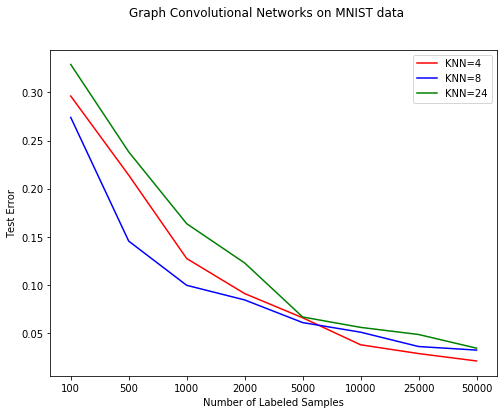

In [45]:
# create plot with all three ks
import matplotlib.pyplot as plt

#fig = plt.figure()
fig= plt.figure(figsize=(8,6))
xIdx = list(range(len(labelSize)))
plt.plot(xIdx,k4_error,'r-',label='KNN=4')
fig.suptitle('Graph Convolutional Networks on MNIST data')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Error')
plt.plot(xIdx,k8_error,'b-',label='KNN=8')
plt.plot(xIdx,k24_error,'g-',label='KNN=24')
plt.legend()
plt.xticks(xIdx,labelSize)
fig.savefig('gcn1.jpg')
plt.show()


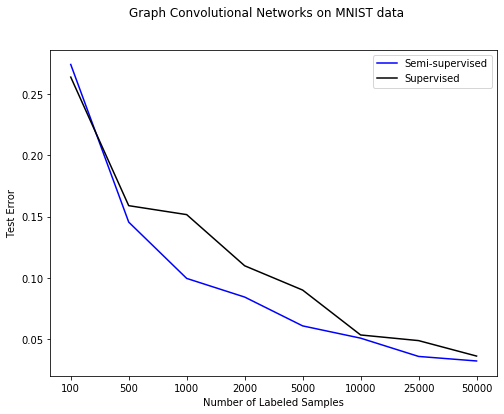

In [46]:
#compare k=8 against supervised learning
#fig = plt.figure()
fig= plt.figure(figsize=(8,6))
xIdx = list(range(len(labelSize)))
plt.plot(xIdx,k8_error,'b-',label='Semi-supervised')
fig.suptitle('Graph Convolutional Networks on MNIST data')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Error')
plt.plot(xIdx,sl_error,'black',label='Supervised')
plt.legend()
plt.xticks(xIdx,labelSize)
fig.savefig('gcn2.jpg')
plt.show()